In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Dense
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2023-10-25 11:25:19.172229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 11:25:21.047339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%run model_toolkit.py
discretizer = Discretizer()
df = load_dataset('datasets/no_noise_circle_diameter500-10000_distance30-60_b0-3/*.npy')
df

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4095,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4096,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4097,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


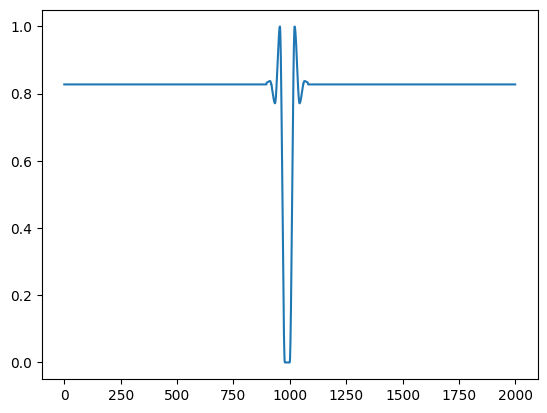

In [12]:
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

timeseries = []

for index, row in df.iterrows():
    scaler=MinMaxScaler()
    timeserie=interpolate.PchipInterpolator(np.arange(start=0, stop=92, step=1), row)(np.linspace(0,92,2000))
    timeserie=np.where(abs(timeserie-1)<=0.001, 1, timeserie)
    timeserie=scaler.fit_transform(timeserie.reshape(-1, 1))
    timeseries.append(timeserie)

timeseries = np.array(timeseries)
plt.plot(timeseries[0])

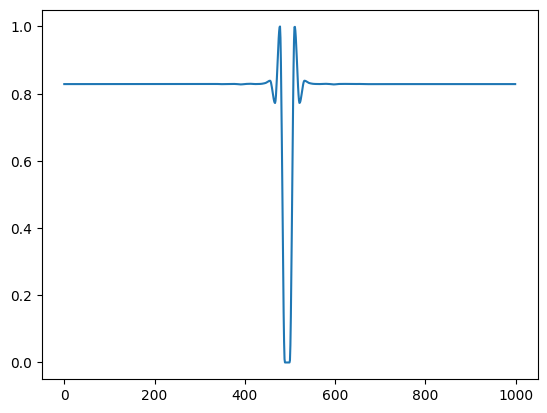

In [7]:
plt.plot(timeseries[0])

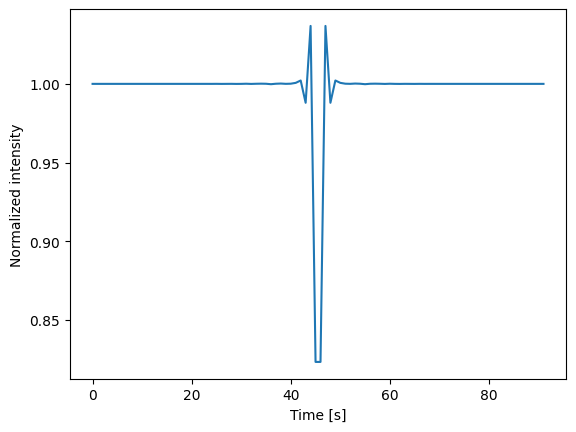

In [32]:
plt.xlabel('Time [s]')
plt.ylabel('Normalized intensity')
df.loc[0].plot();

In [3]:
occultation_features = discretizer.discretize_occultation_features('datasets/no_noise_circle_diameter500-10000_distance30-60_b0-3/taosii_circle_simulation_features.csv')
occultation_features[7]

KeyError: 7

In [61]:
occultation_features.groupby(['diameter']).count()

,distance,impact_parameter
diameter,,
0.0,615,615
1.0,820,820
2.0,820,820
3.0,820,820
4.0,1025,1025


In [62]:
occultation_features.groupby(['distance']).count()

,diameter,impact_parameter
distance,,
1.0,820,820
2.0,3280,3280


In [63]:
occultation_features.groupby(['impact_parameter']).count()

,diameter,distance
impact_parameter,,
0.0,300,300
1.0,200,200
2.0,300,300
3.0,3300,3300


In [1]:
wandb.init(
    project="taos_ii_occultation_detector",
    config={
        'epochs': 1000, 
        'batch_size': 128,
        'learning_rate': 0.8,
        'loss_function': 'sparse_categorical_crossentropy',
        'architecture': 'convolutional neural network',
        'leaky_relu_alpha': 0.1,
        'dataset': 'no_noise_circle_diameter500-10000_distance30-60_b0-3_normalized'
    }
)


config = wandb.config
    
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.layers import LeakyReLU
import math

def get_model(n_inputs, filters=(32, 64, 128, 256, 512), kernel_size=3, dropout_rate=0.2):
    input_layer = Input(shape=(n_inputs,1))
    
    x = input_layer
    for f in filters:
        x = Conv1D(f, kernel_size, kernel_initializer='he_uniform', padding='same')(x)
        x = LeakyReLU(alpha=config['leaky_relu_alpha'])(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Dropout(dropout_rate)(x)
    
    hidden = Flatten()(x)
    
    out_x = Dense(5, activation='softmax', name='out_diameter', kernel_regularizer='l2')(hidden)
    out_y = Dense(3, activation='softmax', name='out_distance', kernel_regularizer='l2')(hidden) 
    out_z = Dense(4, activation='softmax', name='out_impact_parameter', kernel_regularizer='l2')(hidden)
    
    model = Model(inputs=input_layer, outputs=[out_x, out_y, out_z])
    
    optimizer = Adam(config.learning_rate)
    
    def lr_scheduler(epoch, lr):
        decay_rate = 0.8
        decay_step = 1
        if epoch % decay_step == 0 and epoch:
            return lr * math.pow(decay_rate, epoch)
        return lr
    
    callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]
    
    model.compile(optimizer=optimizer, 
                  loss={'out_diameter': config.loss_function, 
                        'out_distance': config.loss_function,
                        'out_impact_parameter': config.loss_function},
                  metrics=['accuracy'])
    
    return model, callbacks


def evaluate_model(X, y):
 n_inputs = X.shape[1]
 cv = RepeatedKFold(n_splits=10, n_repeats=3)
 best_metric = float('inf')
 best_model_path = 'checkpoints/model_classification.keras'
 for train_ix, test_ix in cv.split(X):
     X_train, X_test = X[train_ix], X[test_ix]
        
     y_train_diameter, y_train_ua, y_train_b = y.iloc[train_ix, 0], y.iloc[train_ix, 1], y.iloc[train_ix, 2]
     y_test_diameter, y_test_ua, y_test_b = y.iloc[test_ix, 0], y.iloc[test_ix, 1], y.iloc[test_ix, 2]
     
     model, checkpoints = get_model(n_inputs)
     checkpoint_callback = ModelCheckpoint(
        best_model_path, 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=0
     )
     tensorboard_callback = TensorBoard(log_dir='./logs')
     wandb_callback = WandbCallback(log_weights=True)
    
     model.fit(
         tf.convert_to_tensor(X_train),
         [tf.convert_to_tensor(y_train_diameter), tf.convert_to_tensor(y_train_ua), tf.convert_to_tensor(y_train_b)], 
         verbose=0,
         batch_size=config.batch_size,
         epochs=config.epochs,
         callbacks=[checkpoints, tensorboard_callback, wandb_callback]
     )
        
     current_mae = model.evaluate(
            tf.convert_to_tensor(X_test), 
            [tf.convert_to_tensor(y_test_diameter), tf.convert_to_tensor(y_test_ua), tf.convert_to_tensor(y_test_b)], 
            verbose=0
     )
     
     avg_mae = sum(current_mae) / len(current_mae)
    
     if avg_mae < best_metric:
        best_metric = avg_mae
        model.save(best_model_path) 

evaluate_model(timeseries,occultation_features)

NameError: name 'wandb' is not defined

In [4]:
%run model_toolkit.py

plt = log_results('datasets/no_noise_circle_diameter500-10000_distance30-60_b0-3/taosii_circle_simulation_features.csv', 'datasets/no_noise_circle_diameter500-10000_distance30-60_b0-3/*.npy');
#wandb.log({"confusion_matrix_results": wandb.Image(plt, caption="Confusion matrix")})
plt

ValueError: in user code:

    File "/h1/cesanchez/.conda/envs/py39/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/h1/cesanchez/.conda/envs/py39/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/h1/cesanchez/.conda/envs/py39/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/h1/cesanchez/.conda/envs/py39/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/h1/cesanchez/.conda/envs/py39/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/h1/cesanchez/.conda/envs/py39/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 2000, 1), found shape=(None, 92)
